In [1]:
import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

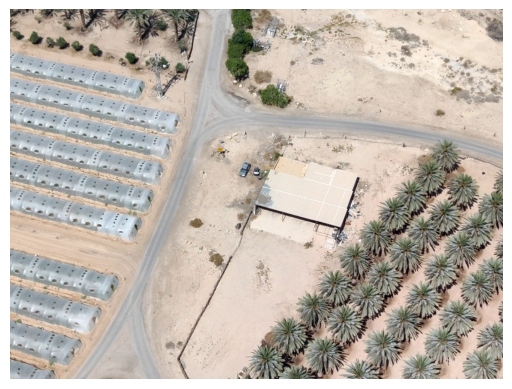

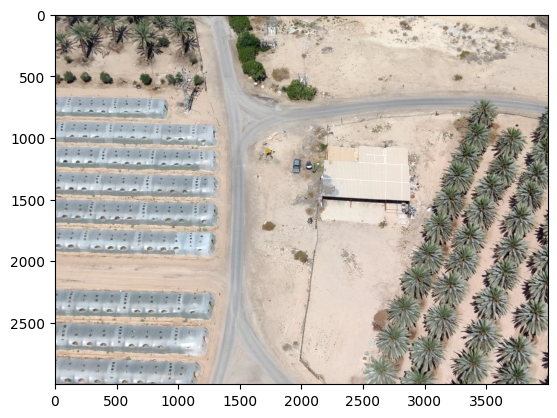

In [106]:
import cv2
import numpy as np

example =cv2.VideoCapture(r"C:\kela\tracker\object-tracker\data\input\MAX_0010.mp4")

example.set(cv2.CAP_PROP_POS_FRAMES, 147*30)

success, frame = example.read()


frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
h, w = frame_rgb.shape[:2]
#Selected bbox (scaled): (1997, 1768, 142, 128)

example.set(cv2.CAP_PROP_POS_FRAMES,150*30 + 50)
success, frame = example.read()
second = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
example.release()
## first quarter
#crop_size = 64


# Crop center region
center_crop = frame_rgb
plt.imshow(center_crop)
plt.axis('off')
plt.show()
plt.imshow(second)

Original size: (3000, 4000, 3)
Display size: (900, 1200, 3)
Scale factor: 0.3

Select ROI on the displayed image...

Selected ROI (scaled): (430, 500, 43, 41)
ROI (original coordinates): (1433, 1666, 143, 136)
ROI crop size: (136, 143, 3)


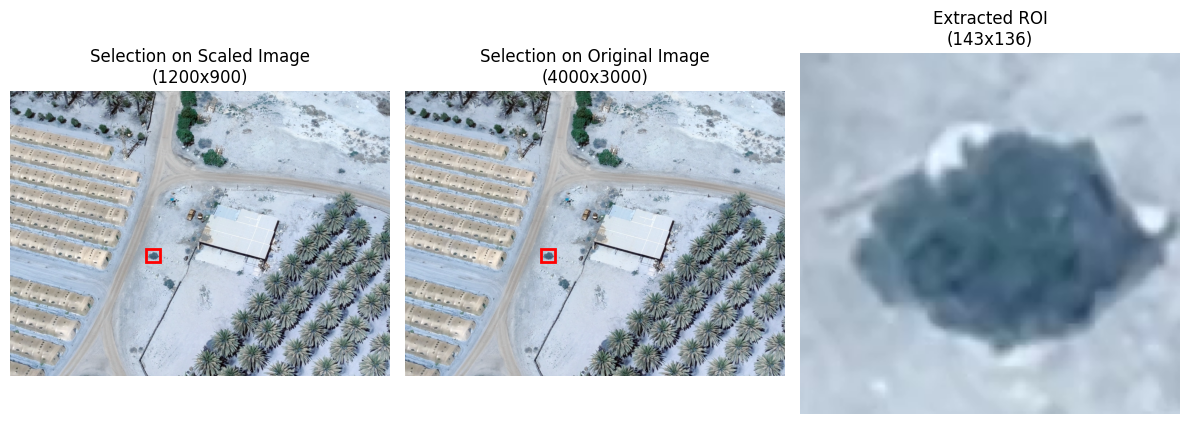

In [107]:
# ============================================================================
# ROI SELECTION WITH SCALING
# ============================================================================

# Save original image
original_frame = center_crop.copy()

# Scale down for display (easier to see on screen)
display_scale = 0.3  # Adjust this to fit your screen
display_frame = cv2.resize(center_crop, 
                          (int(center_crop.shape[1] * display_scale), 
                           int(center_crop.shape[0] * display_scale)))

print(f"Original size: {original_frame.shape}")
print(f"Display size: {display_frame.shape}")
print(f"Scale factor: {display_scale}")

# Select ROI on scaled-down image
print("\nSelect ROI on the displayed image...")
roi = cv2.selectROI("Select Object (press ENTER when done)", display_frame, False, False)
cv2.destroyAllWindows()

x_scaled, y_scaled, w_scaled, h_scaled = roi
print(f"\nSelected ROI (scaled): {roi}")

# Scale ROI coordinates back to original image size
scale_back = 1.0 / display_scale
x_original = int(x_scaled * scale_back)
y_original = int(y_scaled * scale_back)
w_original = int(w_scaled * scale_back)
h_original = int(h_scaled * scale_back)

print(f"ROI (original coordinates): ({x_original}, {y_original}, {w_original}, {h_original})")

# Extract ROI from ORIGINAL image (not scaled)
roi_crop = original_frame[y_original:y_original+h_original, 
                         x_original:x_original+w_original]

print(f"ROI crop size: {roi_crop.shape}")

# Verify the selection
plt.figure(figsize=(12, 5))

plt.subplot(131)
plt.imshow(cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
plt.gca().add_patch(plt.Rectangle((x_scaled, y_scaled), w_scaled, h_scaled,
                                  fill=False, edgecolor='red', linewidth=2))
plt.title(f'Selection on Scaled Image\n({display_frame.shape[1]}x{display_frame.shape[0]})')
plt.axis('off')

plt.subplot(132)
plt.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
plt.gca().add_patch(plt.Rectangle((x_original, y_original), w_original, h_original,
                                  fill=False, edgecolor='red', linewidth=2))
plt.title(f'Selection on Original Image\n({original_frame.shape[1]}x{original_frame.shape[0]})')
plt.axis('off')

plt.subplot(133)
plt.imshow(cv2.cvtColor(roi_crop, cv2.COLOR_BGR2RGB))
plt.title(f'Extracted ROI\n({roi_crop.shape[1]}x{roi_crop.shape[0]})')
plt.axis('off')

plt.tight_layout()
plt.show()

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================================================================
# SETUP VGG WITH SPATIAL FEATURES
# ============================================================================

# Load VGG16
vgg = models.vgg16(pretrained=True)

# Extract features up to conv4_3

feature_extractor = vgg.features[:30]  # Up to conv4_3 (before pooling)
# If you want conv5_3: use [:30]

feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

print("VGG feature extractor loaded")


# ============================================================================
# EXTRACT SPATIAL FEATURES (NO GLOBAL POOLING!)
# ============================================================================

def extract_spatial_features_vgg(image, model, target_size=None):
    """
    Extract spatial feature maps from VGG
    
    Args:
        image: numpy array (H, W, 3) in BGR
        model: VGG feature extractor
        target_size: (H, W) to resize image, or None to keep original
    
    Returns:
        features: (C, H', W') spatial feature maps
        image_size: (H, W) of the processed image
    """
    # Convert BGR to RGB
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Optionally resize
    if target_size is not None:
        image = cv2.resize(image, target_size)
    
    # Transform
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    # Extract features (keep spatial structure!)
    with torch.no_grad():
        features = model(img_tensor)  # (1, 512, H', W')
    
    return features.squeeze(0), image.shape[:2]


# ============================================================================
# IMPROVED SPATIAL TEMPLATE MATCHING
# ============================================================================

def spatial_template_matching_fixed(template_features, search_features, method='ncc'):
    """
    Cross-correlate template features with search features
    
    Args:
        template_features: (C, H_t, W_t)
        search_features: (C, H_s, W_s)
        method: 'ncc' (normalized cross-correlation) or 'cosine' (cosine similarity)
    
    Returns:
        similarity_map: (H_out, W_out) where each value is similarity score
        valid_mask: (H_out, W_out) boolean mask of valid (non-border) regions
    """
    C, H_t, W_t = template_features.shape
    C, H_s, W_s = search_features.shape
    
    if method == 'cosine':
        # METHOD 1: Cosine similarity (your original approach, but fixed)
        # Normalize per spatial location
        template_norm = F.normalize(template_features, dim=0)
        search_norm = F.normalize(search_features, dim=0)
        
        template_kernel = template_norm.unsqueeze(0)  # (1, C, H_t, W_t)
        search_input = search_norm.unsqueeze(0)        # (1, C, H_s, W_s)
        
        similarity_map = F.conv2d(search_input, template_kernel, padding=0)
        similarity_map = similarity_map.squeeze().cpu().numpy()
        
    elif method == 'ncc':
        # METHOD 2: Normalized Cross-Correlation (BETTER!)
        # This handles partial overlaps correctly
        
        # Prepare for convolution
        template_kernel = template_features.unsqueeze(0)  # (1, C, H_t, W_t)
        search_input = search_features.unsqueeze(0)       # (1, C, H_s, W_s)
        
        # Compute means
        ones_kernel = torch.ones_like(template_kernel)
        template_mean = template_features.mean(dim=0, keepdim=True)  # (1, H_t, W_t)
        
        # Search means at each location
        search_sum = F.conv2d(search_input, ones_kernel, padding=0)  # (1, 1, H_out, W_out)
        search_mean = search_sum / (C * H_t * W_t)
        
        # Center the features
        template_centered = template_features - template_mean  # (C, H_t, W_t)
        
        # Cross-correlation of centered features
        template_kernel_centered = template_centered.unsqueeze(0)
        
        # Numerator: sum of (template_centered * search_centered) at each location
        numerator = F.conv2d(search_input, template_kernel_centered, padding=0)  # (1, 1, H_out, W_out)
        
        # This is approximate NCC - for true NCC we'd need to center search patches individually
        # But this is much faster and works well in practice
        
        # Denominator: std of template * std of search patch
        template_std = template_centered.pow(2).sum().sqrt()
        
        # Approximate search std at each location (not perfect but fast)
        search_sq = search_input.pow(2)
        search_sq_sum = F.conv2d(search_sq, ones_kernel, padding=0)
        search_variance = (search_sq_sum / (C * H_t * W_t)) - search_mean.pow(2)
        search_std = search_variance.sqrt().clamp(min=1e-8)
        
        # NCC score
        similarity_map = numerator / (template_std * search_std + 1e-8)
        similarity_map = similarity_map.squeeze().cpu().numpy()
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Create valid mask (exclude borders)
    H_out, W_out = similarity_map.shape
    border_margin = max(2, min(H_t, W_t) // 4)  # Exclude at least 25% of template size from borders
    
    valid_mask = np.ones_like(similarity_map, dtype=bool)
    valid_mask[:border_margin, :] = False  # Top
    valid_mask[-border_margin:, :] = False  # Bottom
    valid_mask[:, :border_margin] = False  # Left
    valid_mask[:, -border_margin:] = False  # Right
    
    return similarity_map, valid_mask


# ============================================================================
# PEAK DETECTION WITH QUALITY METRICS
# ============================================================================

def find_best_peak(similarity_map, valid_mask):
    """
    Find the best peak considering both absolute score and relative prominence
    
    Returns:
        best_score: float
        best_position: (y, x) tuple
        peak_quality: dict with quality metrics
    """
    # Apply valid mask
    masked_map = similarity_map.copy()
    masked_map[~valid_mask] = -np.inf
    
    if np.all(np.isinf(masked_map)):
        return -np.inf, (0, 0), {}
    
    # Find peak
    peak_score = masked_map.max()
    peak_position = np.unravel_index(masked_map.argmax(), masked_map.shape)
    
    # Compute quality metrics
    valid_scores = similarity_map[valid_mask]
    
    if len(valid_scores) > 0:
        mean_score = valid_scores.mean()
        std_score = valid_scores.std()
        
        # Peak-to-sidelobe ratio
        psr = (peak_score - mean_score) / (std_score + 1e-8)
        
        # Second best peak (for uniqueness)
        masked_map_no_peak = masked_map.copy()
        # Suppress region around peak
        y, x = peak_position
        suppress_radius = 5
        y_min = max(0, y - suppress_radius)
        y_max = min(masked_map.shape[0], y + suppress_radius + 1)
        x_min = max(0, x - suppress_radius)
        x_max = min(masked_map.shape[1], x + suppress_radius + 1)
        masked_map_no_peak[y_min:y_max, x_min:x_max] = -np.inf
        
        second_best = masked_map_no_peak.max() if not np.all(np.isinf(masked_map_no_peak)) else peak_score
        
        quality = {
            'peak_score': peak_score,
            'mean_score': mean_score,
            'std_score': std_score,
            'psr': psr,  # Peak-to-Sidelobe Ratio (higher is better)
            'second_best': second_best,
            'uniqueness': peak_score - second_best,  # How much better than 2nd best
        }
    else:
        quality = {
            'peak_score': peak_score,
            'psr': 0,
            'uniqueness': 0,
        }
    
    return peak_score, peak_position, quality


# ============================================================================
# MULTI-SCALE SPATIAL SEARCH (IMPROVED)
# ============================================================================

def multiscale_spatial_search(template, search_image, scales=[0.5, 1.0, 1.5], 
                              min_template_size=5, method='ncc'):
    """
    Search for template in search image at multiple scales using spatial features
    
    Args:
        template: (H, W, 3) BGR image
        search_image: (H, W, 3) BGR image
        scales: list of scale factors
        min_template_size: minimum template size in feature space (to avoid too small templates)
        method: 'ncc' or 'cosine'
    """
    # Extract search image features once
    print("Extracting search image features...")
    search_features, search_size = extract_spatial_features_vgg(search_image, feature_extractor)
    print(f"Search features: {search_features.shape}")
    
    # Determine stride (depends on VGG layer used)
    # conv4_3 (before pooling): stride = 8
    # conv4_3 (after pooling): stride = 16
    stride = 16 # Adjust based on your layer
    
    best_result = {
        'score': -np.inf,
        'x': 0, 'y': 0, 'w': 0, 'h': 0,
        'scale': 1.0,'rortate': 0,
        'quality': {},
        'similarity_map': None
    }
    
    all_results = []
    rotation_angles = [0, 90, 180,  270] 
    for scale in scales:
        for rotation in rotation_angles:
            print(f"\n{'='*60}")
            print(f"Scale {scale}x:")
            
            # Resize template
            scaled_h = int(template.shape[0] * scale)
            scaled_w = int(template.shape[1] * scale)
            
            if scaled_h >= search_image.shape[0] or scaled_w >= search_image.shape[1]:
                print(f"  ❌ Skipping (template too large: {scaled_h}x{scaled_w})")
                continue
            
            scaled_template = cv2.resize(template, (scaled_w, scaled_h))
            if rotation != 0:
                rotated_template = cv2.rotate(scaled_template,
                                              {90: cv2.ROTATE_90_CLOCKWISE,
                                               90: cv2.ROTATE_90_CLOCKWISE,
                                               180: cv2.ROTATE_180,
                                               270: cv2.ROTATE_90_COUNTERCLOCKWISE}[rotation])
                                              
            else:
                rotated_template = scaled_template
            # Extract template features
            template_features, _ = extract_spatial_features_vgg(rotated_template, feature_extractor)
            
            # Check minimum size
            if template_features.shape[1] < min_template_size or template_features.shape[2] < min_template_size:
                print(f"  ❌ Skipping (template features too small: {template_features.shape})")
                continue
            
            print(f"  Template features: {template_features.shape}")
            
            # Spatial matching with valid region detection
            similarity_map, valid_mask = spatial_template_matching_fixed(
                template_features, search_features, method=method
            )
            
            print(f"  Similarity map: {similarity_map.shape}")
            print(f"  Valid region: {valid_mask.sum()} / {valid_mask.size} positions")
            
            # Find best peak with quality metrics
            peak_score, peak_position, quality = find_best_peak(similarity_map, valid_mask)
            
            if np.isinf(peak_score):
                print(f"  ❌ No valid matches found")
                continue
            
            peak_y_feat, peak_x_feat = peak_position
            
            # Convert from feature map coordinates to image coordinates
            y_img = peak_y_feat * stride
            x_img = peak_x_feat * stride
            
            result = {
                'score': peak_score,
                'x': x_img,
                'y': y_img,
                'w': scaled_w,
                'h': scaled_h,
                'scale': scale,
                'quality': quality,
                'similarity_map': similarity_map,
                'valid_mask': valid_mask
            }
            
            all_results.append(result)
            
            print(f"  📍 Peak: ({peak_x_feat}, {peak_y_feat}) in feature space")
            print(f"  📍 Image coords: ({x_img}, {y_img})")
            print(f"  📊 Score: {peak_score:.3f}")
            print(f"  📊 PSR (peak-to-sidelobe ratio): {quality.get('psr', 0):.3f}")
            print(f"  📊 Uniqueness: {quality.get('uniqueness', 0):.3f}")
            
            # Update best result based on PSR (not just raw score!)
            # This prevents edge artifacts from winning
            if quality.get('psr', 0) > best_result['quality'].get('psr', -np.inf):
                best_result = result
                print(f"  ✅ New best match!")
    
    return best_result, all_results



    
print("\n" + "="*60)
print("Starting improved multi-scale spatial search with VGG...")
print("="*60)
    
    # Uncomment when you have your images:
best_match, all_matches = multiscale_spatial_search(
         roi_crop, 
         second,
         scales=[0.3,0.5,0.7, 1.0, 1.3,1.5,1.8],
         min_template_size=5,
         method='ncc'  # Try 'ncc' or 'cosine'
)
    
print(f"\n{'='*60}")
print(f"🎯 BEST MATCH:")
print(f"  Scale: {best_match['scale']}x")
print(f"  Location: ({best_match['x']}, {best_match['y']})")
print(f"  Size: {best_match['w']}x{best_match['h']}")
print(f"  Score: {best_match['score']:.3f}")
print(f"  PSR: {best_match['quality']['psr']:.3f}")
print(f"{'='*60}")

VGG feature extractor loaded

Starting improved multi-scale spatial search with VGG...
Extracting search image features...
Search features: torch.Size([512, 187, 250])

Scale 0.3x:
  ❌ Skipping (template features too small: torch.Size([512, 2, 2]))

Scale 0.3x:
  ❌ Skipping (template features too small: torch.Size([512, 2, 2]))

Scale 0.3x:
  ❌ Skipping (template features too small: torch.Size([512, 2, 2]))

Scale 0.3x:
  ❌ Skipping (template features too small: torch.Size([512, 2, 2]))

Scale 0.5x:
  ❌ Skipping (template features too small: torch.Size([512, 4, 4]))

Scale 0.5x:
  ❌ Skipping (template features too small: torch.Size([512, 4, 4]))

Scale 0.5x:
  ❌ Skipping (template features too small: torch.Size([512, 4, 4]))

Scale 0.5x:
  ❌ Skipping (template features too small: torch.Size([512, 4, 4]))

Scale 0.7x:
  Template features: torch.Size([512, 5, 6])
  Similarity map: (183, 245)
  Valid region: 43139 / 44835 positions
  📍 Peak: (104, 104) in feature space
  📍 Image coords: (

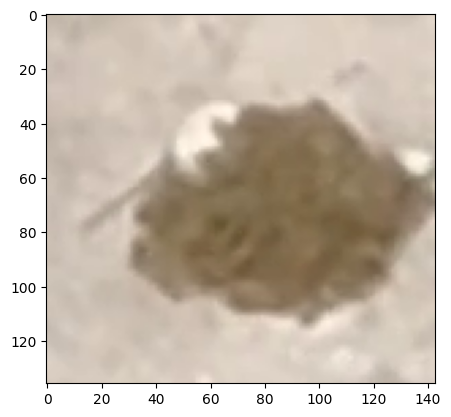

In [109]:
## CROP second image with location found
x, y, w, h = best_match['x'], best_match['y'], best_match['w'], best_match['h']
#1856, 784
cropped_second = second[y:y+h, x:x+w]
plt.imshow(cropped_second)